# Gaussian mixture model example

## Model

We are interested in estimating the labels and means of a Gaussian mixture model (GMM) given $N$ data points.
Specifically, we observe $Y_1,\dots,Y_N\overset{\mathrm{i.i.d.}}{\sim} \pi$, 
where $p$ is a GMM with $K\in\mathbb{N}$ Gaussian components and known weights $w_1,\dots,w_K$:

$$
    \pi = \sum_{k=1}^K w_k \phi_{\mu_k,\sigma_k},
$$
where $\phi_{\mu,\sigma}$ is a $\mathcal{N}(\mu,\sigma^2)$ distribution.
We assume that the number of components $K$ is known, 
as are the variances $\sigma_1^2,\dots,\sigma_K^2$ and weights $w$.

We can formulate the GMM as a hierarchical model by introducing discrete latent variables (labels)
$x_1,\dots,x_N\in\{1,\dots,K\}$
that indicate the component to which each observation belongs,
i.e., $y_n\sim\phi_{\mu_k,\sigma_k} \iff x_n=k$.
We can use the labels to rewrite the likelihood as a product over the sample and label indices:

$$
    \ell(y_{1:N}; \mu_{1:K}, x_{1:N}) 
    = \prod_{n=1}^N \prod_{k=1}^K (w_k \phi_{\mu_k,\sigma_k}(y_n))^{\mathbb{I}(x_n=k)},
$$
where (by a slight abuse of notation) $\phi_{\mu,\sigma}(y)$ is the density of a 
$\mathcal{N}(\mu,\sigma^2)$ distribution evaluated at $y\in\mathbb{R}$.


## Prior distributions

We consider uninformative and independent prior distributions for each of the $K+N$ parameters.
Specifically, we use the known weights $w_{1:N}$ for each $x_n$ and 
assign an isotropic zero-mean Gaussian for the means:

$$
    X_n \sim \mathrm{Categorical}(w_1,\dots,w_N), \quad
    \mu_k \sim \mathcal{N}(0,\sigma_0^2)
$$
for all $n\in[N]$ and $k\in[K]$, where we chose a label-common prior variance $\sigma_0^2\gg0$.


## Posterior distribution

We can write down the posterior distribution by joining the likelihood and the priors:

$$
    p(x_{1:N},\mu_{1_K}\,|\,y_{1:N})\propto
    \left(\mathrm{Categorical}(w_1,\dots,w_N)^N \right) \times
    \left(\prod_{k=1}^K\phi_{0,\sigma_0}(\mu_k)\right) \times
    \left(\prod_{n=1}^N \prod_{k=1}^K (w_k \phi_{\mu_k,\sigma_k}(y_n))^{\mathbb{I}(x_n=k)}\right).
$$


## Gibbs sampling

We devise a Gibbs sampler to learn the labels and means of the GMM.
We first obtain the full conditional distributions,
which have a closed form due to the structure of the problem.

Specifically, the full conditional of each individual label $x_n$, $n\in[N]$ fixed,
can be obtained by working with the terms directly affected by $x_n$:

$$
    p(x_n=k\,|\,\mu_{1_K},y_{1:N})\propto 
    w_k\prod_{\tilde{k}}^K (w_{\tilde{k}} 
    \phi_{\mu_{\tilde{k}},\sigma_{\tilde{k}}}(y_n))^{\mathbb{I}(x_n={\tilde{k}})}.
$$

In this case, all the indicator functions are 0 except for $x_n=k$, and so

$$
    p(x_n=k\,|\,\mu_{1_K},y_{1:N})\propto w_k\phi_{\mu_k,\sigma_k}(y_n),
$$

a scaled Gaussian distribution.

Similarly, we can leverage the "complete the quadratic expression" trick to obtain the
full conditional of each mean $\mu_k$, which corresponds to a Gaussian centered at a scaled sample mean:

$$
    p(\mu_k\,|\,x_{1:N},y_{1:N})=\phi_{\tilde{y}_{(k)},\tilde{\sigma}_{(k)}}(\mu_k),
$$

where $\tilde{y}_{(k)}$ and $\tilde{\sigma}_{(k)}^2$ combine the sample 
(via the sample mean and sample variance) with the prior information on $\mu_k$ from the prior:

$$
    \tilde{y}_{(k)} = \frac{1}{N_{(k)}+\tau_0} \sum_{n=1}^N y_n \mathbb{I}(x_n=k),\\
    \tilde{\sigma}_{(k)}^2 = \frac{1}{N_{(k)}+\tau_0}.
$$

Here, $\tau_0=\sigma_0^{-2}$ is the prior precision and $N_{(k)}=\sum_{n=1}^N \mathbb{I}(x_n=k)$
is the number of samples currently in cluster $k$,
which ensures that only data points in each active cluster are averaged.
The quantity $N_{(k)}+\tau_0$ can be thought of as the posterior sample size,
which corresponds to the actual sample size plus the amount of information provided by the prior
in terms of sample size (denoted by inverse variance or precision).


## Derandomized Gibbs sampler

We follow Murray and Elliot (2012) to build a derandomized or deterministic version of the Gibbs sampler.
Let $\xi$ be a fixed irrational number, which we will use to construct a deterministic
(but seemingly random) stream of uniform numbers starting at an arbitrary $u^{(0)}\in[0,1]$.
Further, suppose that we can express the update rule as a function $\tau$ of the previous iterate and 
a uniform random variable, say $x^{(t+1)}\gets \tau(x^{(t)}; U)$, with $U\sim\mathsf{Unif}(0,1)$.
If the update is done by generating a random number from a distribution $T(x^{(t+1)}\,|\,x^{(t)})$,
then we can always define $\tau$ as the inverse cdf of $T$.
Likewise, we define $\tilde{\tau}(x^{(t+1)};x^{(t)})$ as the reverse operator, i.e.,
the inverse cdf of the reverse distribution $\tilde{T}(x^{(t)} \,|\, x^{(t+1)})$.

The main idea of Murray and Elliot is to target the extended distribution 
$\tilde{\pi}(\mathrm{d}x,\mathrm{d}u)=\pi(\mathrm{d}x)\otimes\mathsf{Unif}(0,1)(\mathrm{d}u)$
by interleaving three operations:
1. temporarily update the uniform stream via $\tilde{u}^{(t+1)}\gets u^{(t)}+\xi\mod 1$;
2. update the current iterate via $x^{(t+1)}\gets\tau(x^{(t)};\tilde{u}^{(t+1)})$;
3. and update again the uniform stream to ensure that the operator leaves $\tilde{\pi}$ invariant:
$u^{(t+1)}\gets\tilde{\tau}(x^{(t)};x^{(t+1)})$.


### Updating the means

In the GMM example, the distribution of the new mean given the current parameters is Gaussian:

$$
    T(\mu_k^{(t+1)} \,|\, \mu_{-k}^{(t)}, x^{(t)}) = \phi_{\tilde{y}_{(k)},\tilde{\sigma}_{(k)}},
    \quad k\in[K],t\in\mathbb{N}.
$$

We can then express the operator as a function of a uniform random variate via the Normal cdf:

$$
    \tau(\mu_{-k}^{(t)}, x^{(t)}; u^{(t+1)}) = \Phi_{\tilde{y}_{(k)},\tilde{\sigma}_{(k)}}^{-1}(u^{(t+1)}).
$$

Hence steps 1. and 2. are easy to implement for each of the $K$ mean parameters.

**Where I am stuck now:** I have no idea how to obtain the inverse operator $\tilde{\tau}$.
Note that we can still set it up to be the inverse cdf of $\tilde{T}$,
the distribution of the old parameters $\mu_{-k}^{(t)}, x^{(t)}$ given the updated mean $\mu_k^{(t+1)}$.
But I am having trouble working out that distribution since $T$ depends only on the cluster mean and sd,
$\tilde{y}_{(k)},\tilde{\sigma}_{(k)}$.
Also note that $\mu_{-k}$ are all independent of $\mu_k$, but I'm not sure how that comes into play
(do I only look for the distribution of the labels given the new mean?).


### Updating the labels

The strategy is the same: express the "generate a random variate" process as a function of a uniform r.v.
by using the quantile function.
In this case, recall that for $n=1,\dots,N$ the distribution of the labels given the means (and other labels)
is categorical where each probability is proportional to a Gaussian density:

$$
    T(x_n^{(t+1)} \,|\, \mu^{(t)}, x_{-n}^{(t)}) = \mathsf{Categorical}(p_1,\dots,p_K), \quad
    p_k \propto \phi_{\mu_k,\sigma_k}(y_n) \text{ for } k\in[K].
$$

The cdf of the categorical distribution evaluated at $m\in\mathbb{N}$
is the sum of probabilities up to category $m$,
$
    \sum_{k=1}^m p_k,
$
and so the quantile function (or inverse cdf)
is the minimum number of terms in the sum needed to reach the desired probability:

$$
    \tau(\mu^{(t)}, x_{-n}^{(t)}; u) = \min \left\{m\in[K] \,\Big|\, \sum_{k=1}^m p_k < u \right\}.
$$

So again, implementing steps 1. and 2. is easy for the labels as well.

**Where I am stuck now:** I also don't know how to find the reverse operator or distribution. Still working on this.

## How to solve it
**(July  12 meeting notes)**

Basically: do exactly the same as in variational ergodic flows when refreshing the momentum variables.
The idea here is that Murray and Elliot trap themselves by using the traditional inverse cdf trick
to simulate from the full conditionals.
This in turns requires them to update their pseudotime $u$ to ensure that their map is measure-preserving.

Instead of using the inverse cdf as a deterministic map,
we can map the current iterate $x_t$ to [0,1] space via $F_T(x_t)$
(where $F_T$ is the cdf of $T(x_{t+1}\,|\,x_t)$, the full conditional distribution);
do a "vertical" shift by adding $z(u_t)$ modulo 1
(where $z$ is a "pseudorandom" function that might also depend on
the other "position" variables other than $x_t$);
and map back to $x$ space by applying the inverse cdf $F_T^{-1}$.
This procedure still simulates sampling from $T$,
but with the crucial benefit that no further adjustment to the pseudotime is needed
since the transformation being applied is measure-preserving.

Formally, this is how the position updates look for Murray vs for this idea:

\begin{align}
    x_{t+1} &\gets F_T^{-1}(\tilde{u}_{t+1}; x_t) && (\text{Murray and Elliot})\\
    x_{t+1} &\gets F_T^{-1}(F_T(x_t)+z(u_{t+1}) \mod 1) && (\text{new idea}).
\end{align}

In both cases the pseudotimes were updated before, $u_{t+1},\tilde{u}_{t+1} \gets u_t+\xi\mod 1$,
but we note the tilde that denotes that the Murray and Elliot approach requires a further pseudotime update.
I have implemented this idea, at the end of this ipynb.

In [1]:
##########################
##########################
# preamble      ##########
##########################
##########################
using Plots, ForwardDiff, ReverseDiff, LinearAlgebra, Printf, Random, Distributions, LaTeXStrings, SpecialFunctions, Suppressor, MLJ

## Data generation

We generate and plot the data from the model.

In [2]:
##########################
##########################
# generate data ##########
##########################
##########################

# mixture settings
N = 1000                   # sample size
K = 3                      # number of components in the mixture
mu = [-7.5,0.,7.5]           # component means
sd = [1.5, 1.5, 1.5]       # component standard deviations
w = [0.2, 0.5, 0.3]        # component weights
z = rand(Categorical(w),N) # component labels

# generate sample
y = sd[z].*rand(Normal(),N)+mu[z];

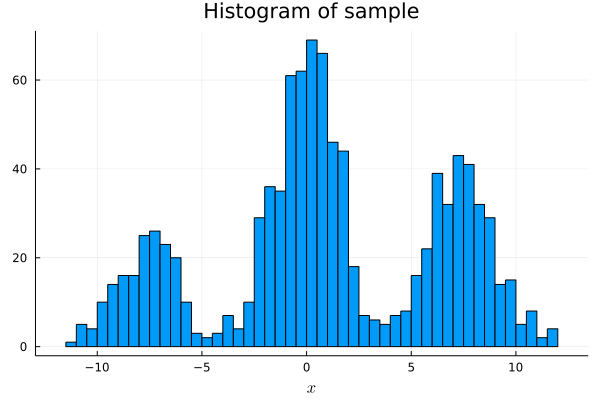

In [3]:
# plot data
histogram(y, bins=100, title="Histogram of sample", xlabel=L"x", legend=false)

## Implementing the Gibbs sampler

We develop functions to sample from the full conditionals and use them in a Gibbs sampler.
We run the sampler for 1,000 iterations,
and initialize the means at 0 and the labels as random assignments according to the known weights
(which corresponds to their prior distribution).

Instead of doing a regular burn-in, we discard all samples but the last.

In [4]:
##########################
##########################
# code model    ##########
##########################
##########################
tau0=0.1

function update_probs(mu,yn)
    # update p(xn=k|mu,yn)
    K = size(mu,1)
    p = zeros(K)
    for k in 1:K
        p[k] = pdf(Normal(mu[k],sd[k]),yn)
    end
    return p/sum(p)
end

function rand_xgivenmu(p,B)
    # sample from Xn | mu,yn with probs p from update_probs       
    return rand(Categorical(p),B)
end

function rand_mugivenx(k,x,y,B)
    # sample from muk | x,y
    Nk = sum(x.==k)
    yktilde = sum(y[x.==k])/(Nk+tau0)
    sigmak2tilde = 1/(Nk+tau0)
    return rand(Normal(yktilde,sqrt(sigmak2tilde)),B)
end

rand_mugivenx (generic function with 1 method)

In [5]:
##########################
##########################
# gibbs sampling #########
##########################
##########################
Random.seed!(2022);

# setup
iters=1000
means = zeros(K)
labels = rand(Categorical(w),N)

for t in 1:iters
    # update labels
    for n in 1:N
        pn = update_probs(means,y[n])
        labels[n] = rand_xgivenmu(pn,1)[1]
    end
    
    # update means
    for k in 1:K
        means[k] = rand_mugivenx(k,labels,y,1)[1]
    end
end

### Diagnostics

We now show the histogram of the data along with the observations.
We color each data point according to the label $x_n$ from the Gibbs sampler,
and plot the estimated means as well.

In [6]:
# relabel to match order in z, which is increasing
sigma = sortperm(means) # finds the permutation to sort the labels
mus = means[sigma];
x = zeros(size(labels,1))
for i in 1:size(labels,1)
    x[i] = findfirst(isequal(labels[i]), sigma)
end
x = Int.(x);

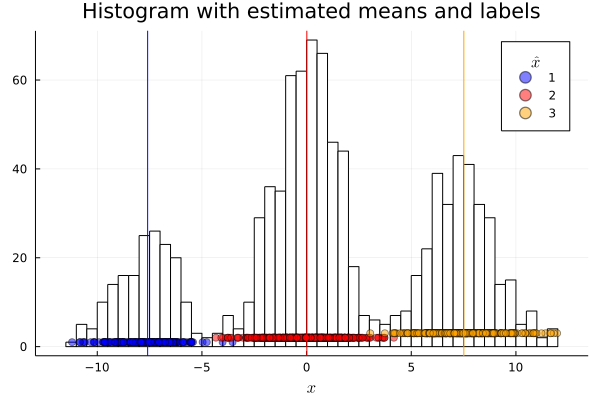

In [7]:
colors = ["blue", "red", "orange"]

pl = histogram(y, bins=50, title="Histogram with estimated means and labels",
    xlabel=L"x", color = "white", label="", legendtitle = L"\hat{x}")
for k in 1:K
    pl = scatter!(y[x.==k],zeros(size(y[x.==k])).+k, c = colors[k], label = string(k), alpha = 0.5)
    pl = vline!([mus[k]], c = colors[k], label ="")
end
display(pl)

The algorithm seems to have separated all three components of the mixture and
correctly labeled the data points.

We also calculate the confusion matrix $M$, where $M_{ij}$ refers to the number of data points
equal to $i$ and classified as $j$ by the Gibbs sampler.

In [8]:
function MyConfusionMatrix(y::Vector{Int64},pred::Vector{Int64})
    # create a confusion matrix
    M = zeros((size(unique(y))[1],size(unique(y))[1]))
    idxs = size(M,1)
    for i in 1:idxs
        for j in 1:idxs
            M[i,j] = sum(y.==i .&& pred.==j)
        end
    end
    return Int.(M)
end

MyConfusionMatrix(z,x)

3×3 Matrix{Int64}:
 176    5    0
   1  500    6
   0    0  312

As we see, the majority of the data points were correctly labeled.

## Derandomized Gibbs with new idea

Here we implement the Murray and Elliot derandomized Gibbs sampler
with the new idea of cdf+vertical shift+inverse cdf updte.

In [9]:
##########################
##########################
# code transitions #######
##########################
##########################
zrandom = (x,u)->sin(2022*x+u)

function taumu(k,x,y,u)
    # ORIGINAL MURRAY AND ELLIOT
    # deterministically generate new mu_k given x,y,u
    Nk = sum(x.==k)
    yktilde = sum(y[x.==k])/(Nk+tau0)
    sigmak2tilde = 1/(Nk+tau0)
    return quantile(Normal(yktilde,sqrt(sigmak2tilde)),u)
end

function taumu2(k,oldmu,x,y,u)
    # NEW IDEA
    # deterministically generate new mu_k given the previous mu_k, x,y,u using inverse cdf+shift+cdf
    Nk = sum(x.==k)
    yktilde = sum(y[x.==k])/(Nk+tau0)
    sigmak2tilde = 1/(Nk+tau0)
    Tdist = Normal(yktilde,sqrt(sigmak2tilde))
    #println(cdf(Tdist,oldmu))
    #println()
    return quantile(Tdist,mod(cdf(Tdist,oldmu)+zrandom(k,u),1))
end

function taux(p,u)
    # ORIGINAL MURRAY AND ELLIOT
    # deterministically generate new x_n given mu,y,u
    # p comes from calling update_probs
    return quantile(Categorical(p),u)
end

function taux2(oldx,n,p,u)
    # NEW IDEA
    # deterministically generate new x_n given mu,y,u using inverse cdf+shift+cdf
    Tdist = Categorical(p)
    return quantile(Tdist,mod(cdf(Tdist,oldx)+zrandom(n,u),1))
end

taux2 (generic function with 1 method)

In [10]:
##########################
##########################
# derandomized gibbs #####
##########################
##########################
Random.seed!(2022);

# setup
iters=1000
xi = π/16
ux = rand(N)
umu = rand(K)
means = zeros(iters,K)
labels = rand(Categorical([1/3,1/3,1/3]),(iters,N))

for t in 2:iters
    # temp u update
    ux  = mod.(ux .+xi,1)
    umu = mod.(umu.+xi,1)
    
    # update labels
    for n in 1:N
        pn = update_probs(means[t-1,:],y[n])
        #labels[n] = taux(pn,ux[n])
        labels[t,n] = taux2(labels[t-1,n],n,pn,ux[n])
    end
    
    # update means
    for k in 1:K
        #means[k] = taumu(k,labels,y,umu[k])
        means[t,k] = taumu2(k,means[t-1,k],labels[t,:],y,umu[k])
    end
    
    # TODO reupdate uniform variates
    # note necessary in v2
end
final_means = means[iters,:];
final_labels = labels[iters,:];

### Diagnostics

These all look good, I think. Should we consider more examples?

In [11]:
# relabel to match order in z, which is increasing
sigma = sortperm(final_means) # finds the permutation to sort the labels
mus = final_means[sigma]
x = zeros(size(final_labels,1))
for i in 1:size(final_labels,1)
    x[i] = findfirst(isequal(final_labels[i]), sigma)
end
x = Int.(x);

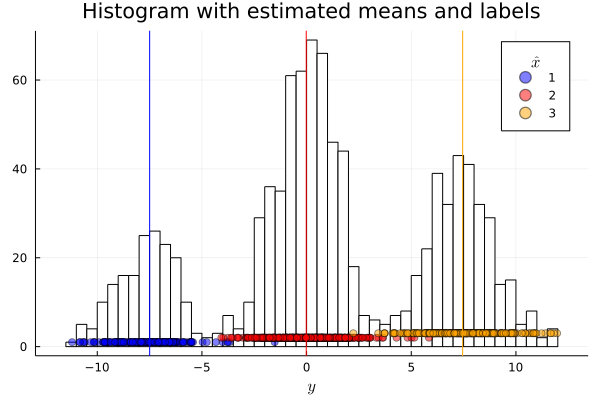

In [12]:
colors = ["blue", "red", "orange"]

pl = histogram(y, bins=50, title="Histogram with estimated means and labels",
    xlabel=L"y", color = "white", label="", legendtitle = L"\hat{x}")
for k in 1:K
    pl = scatter!(y[x.==k],zeros(size(y[x.==k])).+k, c = colors[k], label = string(k), alpha = 0.5)
    pl = vline!([mus[k]], c = colors[k], label ="")
end
display(pl)

In [13]:
MyConfusionMatrix(z,x)

3×3 Matrix{Int64}:
 178    3    0
   3  495    9
   0    4  308

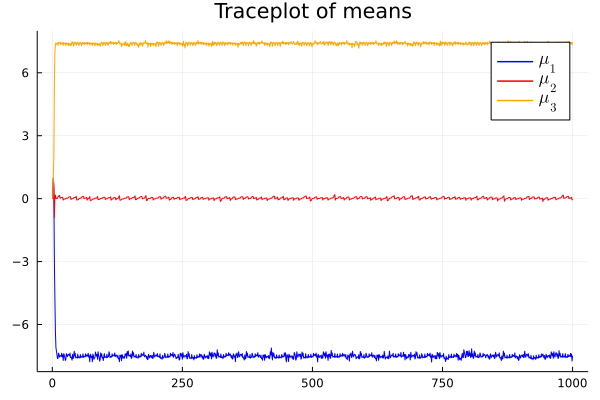

In [14]:
plot(1:iters,means[:,sigma[1]], label = L"\mu_1",legendfontsize=12,title="Traceplot of means", c=colors[1])
plot!(1:iters,means[:,sigma[2]], label = L"\mu_2", c=colors[2])
plot!(1:iters,means[:,sigma[3]], label = L"\mu_3", c=colors[3])

┌ Info: Saved animation to 
│   fn = /home/giank/Dropbox/Documents/ubc/phd-mtgs/discrete-deterministic-gibbs/gmm/transformation_comparison.gif
└ @ Plots /home/giank/.julia/packages/Plots/LI4FE/src/animation.jl:114


Plots.AnimatedGif("/home/giank/Dropbox/Documents/ubc/phd-mtgs/discrete-deterministic-gibbs/gmm/transformation_comparison.gif")
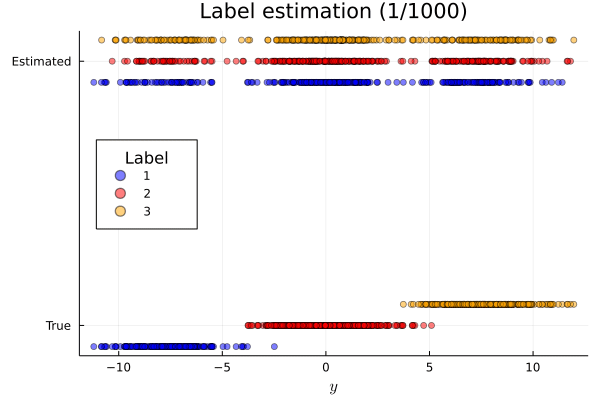

In [18]:
yshift=0.5
anim = Animation()
#iterator = 1:10:iters # even emphasis hard to interpret
iterator = Int.(round.(exp10.(range(0, stop=log10(iters), length=100))))
for t in iterator
    ttl = string("Label estimation (",t,"/",iters,")")
    plot(title=ttl,xlabel=L"y", legendtitle = "Label",legend=:left)
    tmplbls = labels[t,:]
    xx = zeros(size(tmplbls,1))
    for i in 1:size(tmplbls,1)
        xx[i] = findfirst(isequal(tmplbls[i]), sigma)
    end
    xx = Int.(xx);
    for k in 1:K
        scatter!(y[z.==k],zeros(size(y[z.==k])).+k/25, c = colors[k], label = string(k), alpha = 0.5,yticks = ([2/25,yshift+2/25], ["True", "Estimated"]))
        scatter!(y[xx.==k],yshift.+zeros(size(y[xx.==k])).+k/25, c = colors[k], label = "", alpha = 0.5)
    end
    frame(anim)
end
gif(anim, "transformation_comparison.gif", fps = 10)

Note the labels mainly change around the edges of the distributions,
as we would expect.